In [1]:
import math
import numpy as np
import wandb
import pickle
import os
import shapely.wkt as wkt
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from torch_geometric.transforms import LineGraph

import gzip
import xml.etree.ElementTree as ET

import torch
import torch_geometric
from torch_geometric.data import Data

import processing_io as pio
import sys
import os
import joblib

# Add the 'scripts' directory to the Python path
scripts_path = os.path.abspath(os.path.join('..'))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

# Now you can import the gnn_io module
import gnn_io as gio

import gnn_architectures as garch

def load_model(model_path):
    # Load the saved model checkpoint
    checkpoint = torch.load(model_path)
    
    # Extract the state dictionary and configuration
    state_dict = checkpoint['state_dict']
    config = checkpoint['config']
    
    # Initialize the model with the configuration
    model = garch.MyGnn(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        hidden_size=config['hidden_size'],
        gat_layers=config['gat_layers'],
        gcn_layers=config['gcn_layers'],
        output_layer=config['output_layer'],
        # output_layer='gat'
    )
    model.load_state_dict(state_dict)
    return model, config

# Assuming 'highway_mapping' and 'encode_modes' are defined as in your context
highway_mapping = {
    'residential': 0, 'tertiary': 1, 'living_street': 2, 'secondary': 3, 
    'primary': 4, 'trunk_link': 5, 'primary_link': 6, 'motorway': 7, 
    'service': 8, 'unclassified': 9, 'secondary_link': 10, 
    'pedestrian': 11, 'trunk': 12, 'motorway_link': 13, 
    'construction': 14, 'tertiary_link': 15, np.nan: -1
}

def data_to_geodataframe(data, original_gdf):
    # Extract the edge index and node features
    node_features = data.x.numpy()
    target_values = data.y.numpy()

    # Create edge data
    edge_data = {
        'from_node': original_gdf["from_node"].values,
        'to_node': original_gdf["to_node"].values,
        'vol_base_case': node_features[:, 0],  # Assuming capacity is the first feature, and so on
        'capacity_base_case': node_features[:, 1],  
        'capacity_new': node_features[:, 2],  
        'highway': node_features[:, 3],  
        'vol_car': target_values.squeeze()  # Assuming target values are car volumes
    }
    # Convert to DataFrame
    edge_df = pd.DataFrame(edge_data)
    # Create LineString geometry
    edge_df['geometry'] = original_gdf["geometry"].values
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(edge_df, geometry='geometry')
    return gdf

In [2]:
# Parameters to define
model_path = '../../data/trained_models/model_16_07_new.pth'
indices_of_datasets_to_use = [0, 1, 2, 3]

test_data = "../../data/test_data/pop_1pm_policy_in_zone_1.geojson"
base_case = "../../data/test_data/gdf_basecase_mean_pop_1pm.geojson"

directory_path_scalar = "../../data/data_created_during_training_needed_for_testing/"
scaler_y = joblib.load(directory_path_scalar + 'y_scaler.pkl')
scaler_x = joblib.load(directory_path_scalar + 'x_scaler.pkl')
scaler_pos = joblib.load(directory_path_scalar + 'pos_scaler.pkl')

In [3]:
test_data = gpd.read_file(test_data)
base_case = gpd.read_file(base_case)
test_input_linegraph = pio.create_test_data_object(base_case= base_case, test_data = test_data) # check this function if there have been changes in the features of the data
test_data_list = [test_input_linegraph] # we do it for just one test data object, for now.

dataset_only_relevant_dimensions = gio.cut_dimensions(dataset=test_data_list, indices_of_dimensions_to_keep=indices_of_datasets_to_use)
dataset_normalized = gio.normalize_dataset(dataset_only_relevant_dimensions, y_scalar=scaler_y, x_scalar_list=scaler_x, pos_scalar=scaler_pos, directory_path=None)
test_dl = gio.create_dataloader(dataset=dataset_normalized, is_train=False, batch_size=16, train_ratio=0, is_test=True)

Total dataset length: 1


In [4]:
# Function to evaluate the model
# def evaluate(model, test_dl, device):
#     model.eval()  # Set the model to evaluation mode
#     test_loss = 0
#     with torch.no_grad():  # Disable gradient computation
#         for data in test_dl:
#             inputs, targets = data.x.to(device), data.y.to(device)
#             outputs = model(data.to(device))
#             loss = torch.nn.MSELoss()(outputs, targets)
#             test_loss += loss.item()
#     avg_test_loss = test_loss / len(test_dl)
    
#     return avg_test_loss, outputs

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, config = load_model(model_path)
model = model.to(device)
test_loss, outputs = garch.evaluate(model, test_dl, device)
print(f'Test Loss: {test_loss}')

ValueError: Invalid output layer

In [ ]:
# Example usage
gdf = data_to_geodataframe(test_input_linegraph, test_data)

In [ ]:
gdf.head()

,from_node,to_node,vol_base_case,capacity_base_case,capacity_new,highway,vol_car,geometry
0,24972409,24972408,0.038307,0.006037,0.006037,0.5,0.555521,"LINESTRING (2.33869 48.85181, 2.33847 48.85181)"
1,5904976363,24983651,0.049539,0.006037,0.006037,0.4,0.525869,"LINESTRING (2.33874 48.85242, 2.33872 48.85229)"
2,24983651,5904976363,0.010830,0.018110,0.018110,0.4,0.538241,"LINESTRING (2.33872 48.85229, 2.33874 48.85242)"
3,664205947,24972376,0.038909,0.018110,0.018110,0.5,0.530368,"LINESTRING (2.33994 48.85200, 2.33986 48.85181)"
4,24972376,24972375,0.043923,0.006037,0.006037,0.5,0.532413,"LINESTRING (2.33986 48.85181, 2.33909 48.85152)"


In [ ]:
gdf.rename(columns={'vol_car': 'vol_car_change_actual'}, inplace=True)
gdf['vol_car_change_predicted'] = outputs[0].cpu().numpy().squeeze()

In [ ]:
original_values_vol_car_change_actual = scaler_y.inverse_transform(gdf['vol_car_change_actual'].values.reshape(-1, 1))
original_values_vol_car_change_predicted = scaler_y.inverse_transform(gdf['vol_car_change_predicted'].values.reshape(-1, 1))
original_values_vol_base_case = scaler_x[0].inverse_transform(gdf['vol_base_case'].values.reshape(-1, 1))
original_values_capacity_base_case = scaler_x[1].inverse_transform(gdf['capacity_base_case'].values.reshape(-1, 1))
original_values_capacity_new = scaler_x[2].inverse_transform(gdf['capacity_new'].values.reshape(-1, 1))
original_values_highway = scaler_x[3].inverse_transform(gdf['highway'].values.reshape(-1, 1))

gdf['og_highway'] = original_values_highway
gdf['og_vol_car_change_actual'] = original_values_vol_car_change_actual
gdf['og_vol_car_change_predicted'] = original_values_vol_car_change_predicted
gdf['og_vol_base_case'] = original_values_vol_base_case
gdf['og_capacity_base_case'] = original_values_capacity_base_case
gdf['og_capacity_new'] = original_values_capacity_new

gdf.to_file("../../data/visualisation/gdf_pop_1pm_model_output.geojson", driver='GeoJSON')

In [ ]:
gdf.head()

,from_node,to_node,vol_base_case,capacity_base_case,capacity_new,highway,vol_car_change_actual,geometry,vol_car_change_predicted,og_highway,og_vol_car_change_actual,og_vol_car_change_predicted,og_vol_base_case,og_capacity_base_case,og_capacity_new
0,24972409,24972408,0.038307,0.006037,0.006037,0.5,0.555521,"LINESTRING (2.33869 48.85181, 2.33847 48.85181)",0.544973,4.0,-0.174074,-0.556156,7.074074,479.999969,479.999969
1,5904976363,24983651,0.049539,0.006037,0.006037,0.4,0.525869,"LINESTRING (2.33874 48.85242, 2.33872 48.85229)",0.545115,3.0,-1.248148,-0.551005,9.148149,479.999969,479.999969
2,24983651,5904976363,0.010830,0.018110,0.018110,0.4,0.538241,"LINESTRING (2.33872 48.85229, 2.33874 48.85242)",0.572526,3.0,-0.800000,0.441865,2.000000,959.999939,959.999939
3,664205947,24972376,0.038909,0.018110,0.018110,0.5,0.530368,"LINESTRING (2.33994 48.85200, 2.33986 48.85181)",0.572550,4.0,-1.085186,0.442745,7.185185,959.999939,959.999939
4,24972376,24972375,0.043923,0.006037,0.006037,0.5,0.532413,"LINESTRING (2.33986 48.85181, 2.33909 48.85152)",0.572708,4.0,-1.011112,0.448452,8.111111,479.999969,479.999969


/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_10628/2798894429.py:84: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_target_districts['geometry'] = buffered_target_districts.buffer(0.0005)


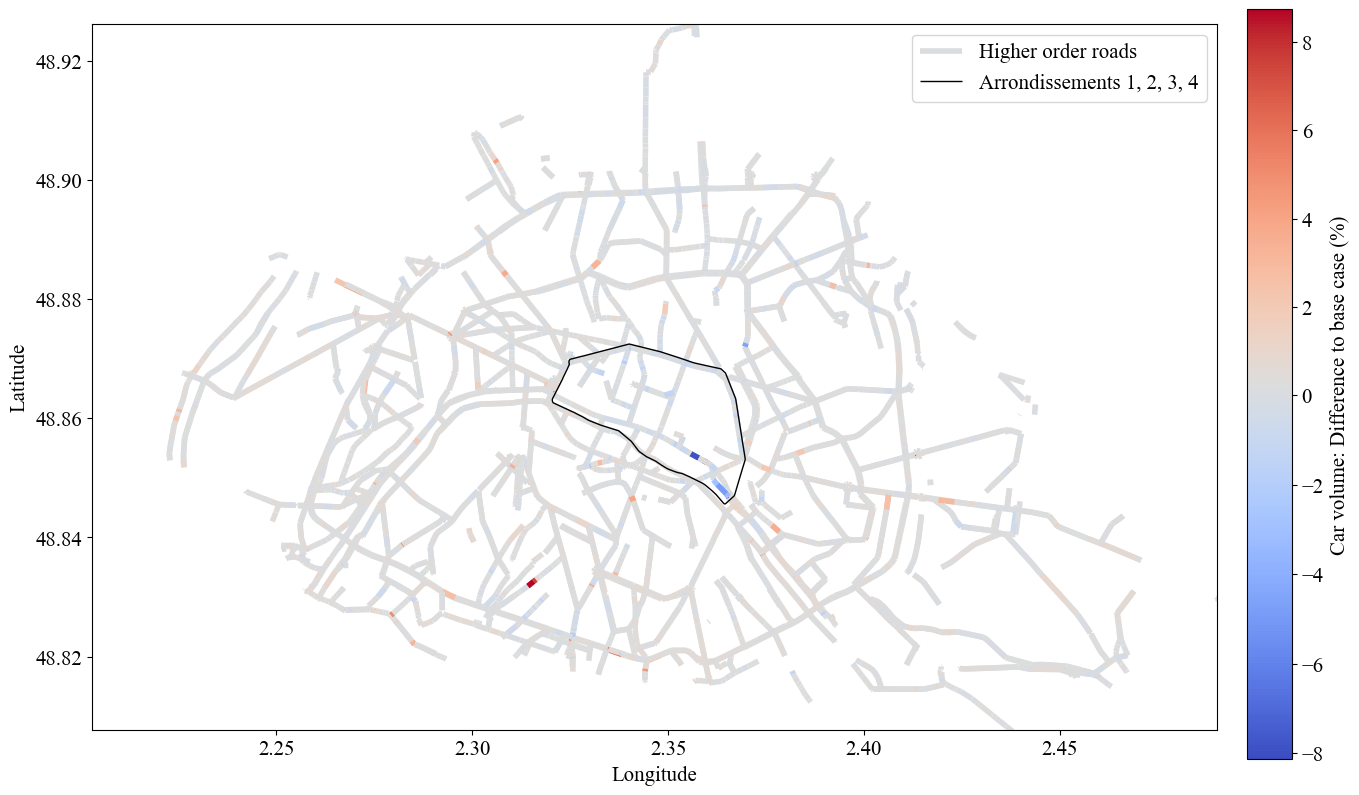

In [ ]:
# import os
# import glob
# import gzip
# import math
# import random
# import pickle

# import numpy as np
# import pandas as pd
# import geopandas as gpd
import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# import matplotlib.cm as cm
from matplotlib.colors import LogNorm
# import shapely.wkt as wkt
from shapely.geometry import Point, LineString, box
# from shapely.ops import nearest_points
# import tqdm
# import wandb
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision
# import torchvision.transforms as T
# from torch.utils.data import DataLoader, Dataset, Subset
# import torch_geometric
# from torch_geometric.data import Data, Batch
# from torch_geometric.transforms import LineGraph
# import re
from matplotlib.colors import TwoSlopeNorm

from shapely.ops import unary_union
from mpl_toolkits.axes_grid1 import make_axes_locatable

districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")

def list_to_string(integers, delimiter=', '):
    """
    Converts a list of integers into a string, with each integer separated by the specified delimiter.

    Parameters:
    integers (list of int): The list of integers to convert.
    delimiter (str): The delimiter to use between integers in the string.

    Returns:
    str: A string representation of the list of integers.
    """
    return delimiter.join(map(str, integers))

# Define the intersects function
def intersects_target(row, target_districts):
    return target_districts.geometry.apply(lambda geom: geom.intersects(row.geometry)).any()
    
def plot_simulation_output(gdf, districts_of_interest: list, column_to_plot = "og_vol_car_change_predicted"):    
    x_min = gdf.total_bounds[0] + 0.05
    y_min = gdf.total_bounds[1] + 0.05
    x_max = gdf.total_bounds[2]
    y_max = gdf.total_bounds[3]
    bbox = box(x_min, y_min, x_max, y_max)
    
    # Filter the network to include only the data within the bounding box
    gdf = gdf[gdf.intersects(bbox)]
    
    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    
    gdf = gdf[gdf["og_highway"].isin([1, 2, 3])]
    
    target_districts = districts[districts['c_ar'].isin(districts_of_interest)]
    gdf['intersects_target_districts'] = gdf.apply(intersects_target, axis=1, target_districts=target_districts)
    # Use TwoSlopeNorm for custom normalization
    norm = TwoSlopeNorm(vmin=gdf[column_to_plot].min(), vcenter=gdf[column_to_plot].median(), vmax=gdf[column_to_plot].max())
    
    # Plot the edges that intersect with target districts thicker
    gdf[gdf['intersects_target_districts']].plot(column=column_to_plot, cmap='coolwarm', linewidth=4, ax=ax, legend=False,
             norm=norm, label = "Higher order roads", zorder=2)
    
    # Plot the other edges
    gdf[~gdf['intersects_target_districts']].plot(column=column_to_plot, cmap='coolwarm', linewidth=4, ax=ax, legend=False,
             norm=norm, zorder=1)
    
    # Add buffer to target districts to avoid overlapping with edges
    buffered_target_districts = target_districts.copy()
    buffered_target_districts['geometry'] = buffered_target_districts.buffer(0.0005)
    # Ensure the buffered_target_districts GeoDataFrame is in the same CRS
    if buffered_target_districts.crs != gdf.crs:
        buffered_target_districts.to_crs(gdf.crs, inplace=True)

    # Create a single outer boundary
    outer_boundary = unary_union(buffered_target_districts.geometry).boundary

    # Plot only the outer boundary
    gpd.GeoSeries(outer_boundary, crs=gdf.crs).plot(ax=ax, edgecolor='black', linewidth=1, label="Arrondissements " + list_to_string(districts_of_interest), zorder=4)

    # ax.set_aspect('equal')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # Customize the plot with Times New Roman font and size 15
    plt.xlabel("Longitude", fontname='Times New Roman', fontsize=15)
    plt.ylabel("Latitude", fontname='Times New Roman', fontsize=15)

    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Times New Roman')
        label.set_fontsize(15)
    ax.legend(prop={'family': 'Times New Roman', 'size': 15})
    ax.set_position([0.1, 0.1, 0.75, 0.75])
    cax = fig.add_axes([0.87, 0.22, 0.03, 0.5])  # Manually position the color bar

    # Create the color bar
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax)
    
    # Set color bar font properties
    cbar.ax.tick_params(labelsize=15)
    for t in cbar.ax.get_yticklabels():
        t.set_fontname('Times New Roman')
    cbar.ax.yaxis.label.set_fontname('Times New Roman')
    cbar.ax.yaxis.label.set_size(15)
    # if in_percentage:
    cbar.set_label('Car volume: Difference to base case (%)', fontname='Times New Roman', fontsize=15)
    # else:
    #     cbar.set_label('Car volume: Difference to base case (absolut)', fontname='Times New Roman', fontsize=15)
    # plt.savefig("results/difference_to_policies_in_zones_" + list_to_string(districts_of_interest, "_") + is_for_1pm, bbox_inches='tight')
    plt.show()

districts_of_interest = [1, 2, 3, 4]
plot_simulation_output(gdf, districts_of_interest=districts_of_interest)